<h1 style="border: 1px solid;color: White; background-color: Gray; padding: 10px">Cyber Security with Jupyter Notebooks</h>
<h2>PyCascades 2022</h2>

Ian Hellen, MSTIC


# Intialization

In [ ]:
import msticpy
msticpy.init_notebook(globals())

If you need to, run this to make any configuration settings.
Save your changes when finished

In [110]:
msticpy.MpConfigEdit()

Label(value='Loading. Please wait.')

In [111]:
# run this if you made any settings changes
msticpy.settings.refresh_config()

---

<h1 style="border: 1px solid;color: White; background-color: Gray; padding: 10px">Data sources and queries</h1>

- Query device and application event logs (including alerts)

Needs:
- Extensible data provider sources
  - Different access methods
  - Different query languages
  - Different authentication requirements
- Parameterized queries
- Returns DataFrame


We build a Query provider facade class that exposes a common interface:
- Based on Intake
- QueryProvider(driver_name)
- connect(connection_string)
- browse_queries() for interactive browser with query help
- exec_query(query) - for ad hoc queries

Built-in queries:
- declarative - YAML
- invoke as Python functions
  - Doc strings are built from YAML query and param descriptions

---

<h1 style="border: 1px solid;color: White; background-color: Gray; padding: 10px">Data Providers - generating functions from configuration</h1>

### Code links:
- [Adding query functions dynamically](https://github.com/microsoft/msticpy/blob/e099a09a600dee3740b10d9ccf4ac836e2cbd3a8/msticpy/data/data_providers.py#L364)
- [Query instance class](https://github.com/microsoft/msticpy/blob/master/msticpy/data/query_source.py)
- [Example queries](https://github.com/microsoft/msticpy/blob/master/msticpy/data/queries/kql_sent_winevent.yaml)
- [Example driver code](https://github.com/microsoft/msticpy/blob/master/msticpy/data/drivers/local_data_driver.py)

### Doc link:

https://msticpy.readthedocs.io/en/latest/data_acquisition/DataProviders.html


In [107]:
qry_prov = QueryProvider("MDE")
qry_prov.connect()
qry_prov.browse()

Connected.


#### Run a query

In [ ]:
qry_prov = QueryProvider("AzureSentinel")
qry_prov.browse()

# Build Data Query Functions

### Define a dict format for queries 

In [ ]:
func_defn = {
    "name": "generic",
    "query": "SELECT {field} from {table}",
    "description": "Select query",
    "params":
        {
            "field": {"type": "str", "description": "column name"},
            "table": {"type": "str", "description": "table name", "default": "TABLE"}
        }
}


### ...and a class to hold them

In [63]:
class QueryInstance:
    
    def __init__(self, defn):
        self.query = defn["query"]
        self.description = defn["description"]
        self.params = defn["params"]
        
    def create_query(self, **kwargs):
        """Returns query with replaced params."""
        return self.query.format(**kwargs)
        
query = QueryInstance(func_defn)

query.create_query(field="user", table="logons")

'SELECT user from logons'

### Let's add a couple of queries

In practice we'd store the queries in YAML or JSON files

In [ ]:
func_defns = {
    "basic": {
        "query": "SELECT {field} from {table}",
        "description": "Basic select query for demo 1",
        "params": {
            "field": {"type": "str", "description": "column name"},
            "table": {"type": "str", "description": "table name", "default": "TABLE"},
        },
    },
    "get_user": {
        "query": "SELECT user from logins where user='{username}'",
        "description": "Get user logins - demo 2",
        "params": {
            "username": {"type": "str", "description": "user name"},
        },
    },
}

### We need a (fake) driver to connect to the data source

In [ ]:
class QueryDriver:

    def connect(self, connect_string):
        # This method handles the connection/authn
        # to the data source
        pass

    def exec_query(self, query):
        """Execute and returns query results."""
        # This function expects to receive an executable
        # query in the `query` parameter, runs the query
        # and converts the results to a DataFrame before
        # returning (we're not doing that last part here.)
        return f"{query}\nSome results 1, 2, 3, 4, 5"



### And a class to hold all this together

In [66]:
class QueryProviderDemo:
    """Query provider facade class"""
    
    def __init__(self, name):
        """Instantiate backend driver and assign."""
        self.name = name
        self.driver = QueryDriver()

    def connect(self, connect_string):
        """Pass connnection details to the driver."""
        self.driver.connect(connect_string)

    def exec_query(self, qry_def, **kwargs):
        """Create query, execute and return results."""
        # ask the QueryInstance to create the query
        # text - using kwargs for the substitutable params
        query_text = qry_def.create_query(**kwargs)
        # ask the driver to run the query and return results
        return self.driver.exec_query(query_text)


qry_prov = QueryProviderDemo("SQL")


### Load the query definitions into the provider

In [67]:
from functools import partial

# Loop through Query definitions in our dictionary
for name, func_def in func_defns.items():
    # create the query_instance from the definition
    qry_inst = QueryInstance(func_def)
    
    # create a partial function passing defn as first parameter
    func = partial(qry_prov.exec_query, qry_def=qry_inst)

    # create a simple doc string 
    func.__doc__ = qry_inst.description
    
    # set this as an attribute on the provider instance
    setattr(qry_prov, name, func)


# Show the new members added to qry_prov
for name, member in vars(qry_prov).items():
    print(name, "\t\t", type(member))

name 		 <class 'str'>
driver 		 <class '__main__.QueryDriver'>
basic 		 <class 'functools.partial'>
get_user 		 <class 'functools.partial'>


In [68]:
# show help working
help(qry_prov.basic)


Help on partial:

functools.partial(<bound method QueryProviderDem...in__.QueryInstance object at 0x00000126DFA5ADC0>)
    Basic select query for demo 1



### Execute query methods, supplying parameter values for the query

In [69]:
results = qry_prov.basic(field="host", table="host_table")
print(results)


SELECT host from host_table
Some results 1, 2, 3, 4, 5


In [70]:
results = qry_prov.get_user(username="ian")
print(results)

SELECT user from logins where user='ian'
Some results 1, 2, 3, 4, 5


## MSTICPy Query examples

### Sentinel provider
```yaml
list_host_processes:
    description: Retrieves list of processes on a host
    args:
      query: '
        let start = datetime({start});
        let end = datetime({end});
        {table}
        | where Computer == "{host_name}"
        | where TimeGenerated >= start
        | where TimeGenerated <= end
        {add_query_items}'
    parameters:
      host_name:
        description: Name of host
        type: str
      start:
        description: Query start time
        type: datetime
      end:
        description: Query end time
        type: datetime
```

### Splunk provider
```yaml
description: Retrieves all configured alerts
    args:
      query: '
      | rest/servicesNS/-/search/saved/searches
      | search alert.track=1
      | fields title description search disabled triggered_alert_count actions action.script.filename alert.severity cron_schedule'
    parameters:
```
### MS Graph OData provider
```yaml
list_alerts:
    description: Retrieves list of alerts
    metadata:
      data_source: 'graph_alert'
    args:
      query: '{path}?$filter=createdDateTime ge {start}
        and createdDateTime le {end} {add_query_items}'
      uri: None
    parameters:
```

### Load MS Defender provider

In [71]:
qry_prov = QueryProvider("MDE")
qry_prov.connect()
qry_prov.list_queries()[:10]

Connected.


['MDATP.file_path',
 'MDATP.host_alerts',
 'MDATP.host_connections',
 'MDATP.ip_alerts',
 'MDATP.ip_connections',
 'MDATP.list_alerts',
 'MDATP.list_connections',
 'MDATP.list_filehash',
 'MDATP.list_files',
 'MDATP.list_host_processes']

In [73]:
help(qry_prov.MDATP.host_connections)

Help on partial:

functools.partial(<bound method QueryProvider._e...uery_path='MDATP', query_name='host_connections')
    Lists alerts by for a specified hostname
    
    Parameters
    ----------
    add_query_items: str (optional)
        Additional query clauses
    end: datetime
        Query end time
    host_name: str
        Name of host
        Aliases: 'hostname'
    start: datetime
        Query start time
    table: str (optional)
        Table name
        (default value is: DeviceNetworkEvents)



In [74]:
qry_prov.MDATP.host_connections(host_name="atevet06cl003.defenderatevet06.onmicrosoft.com")

Timestamp  \
0      2022-01-20 03:33:34.019018+00:00   
1   2022-01-20 03:33:34.020615700+00:00   
2   2022-01-20 03:33:35.019880500+00:00   
3   2022-01-20 03:33:35.020885600+00:00   
4   2022-01-20 03:33:35.022440400+00:00   
..                                  ...   
657 2022-01-21 03:27:22.489094300+00:00   
658 2022-01-21 03:27:22.491110600+00:00   
659 2022-01-21 03:27:22.491722300+00:00   
660 2022-01-21 03:00:05.361794900+00:00   
661 2022-01-21 03:02:13.860205500+00:00   

                                     DeviceId  \
0    624af2e5b912699b82f744daaa9385f74c1c2283   
1    624af2e5b912699b82f744daaa9385f74c1c2283   
2    624af2e5b912699b82f744daaa9385f74c1c2283   
3    624af2e5b912699b82f744daaa9385f74c1c2283   
4    624af2e5b912699b82f744daaa9385f74c1c2283   
..                                        ...   
657  624af2e5b912699b82f744daaa9385f74c1c2283   
658  624af2e5b912699b82f744daaa9385f74c1c2283   
659  624af2e5b912699b82f744daaa9385f74c1c2283   
660  624af2e5b912699b82f744daaa9385f74c1c2283   
661  624af2e5b912699b82f744daaa9385f74c1c2283   

                                         DeviceName  \
0    atevet06cl003.defenderatevet06.onmicrosoft.com   
1    atevet06cl003.defenderatevet06.onmicrosoft.com   
2    atevet06cl003.defenderatevet06.onmicrosoft.com   
3    atevet06cl003.defenderatevet06.onmicrosoft.com   
4    atevet06cl003.defenderatevet06.onmicrosoft.com   
..                                              ...   
657  atevet06cl003.defenderatevet06.onmicrosoft.com   
658  atevet06cl003.defenderatevet06.onmicrosoft.com   
659  atevet06cl003.defenderatevet06.onmicrosoft.com   
660  atevet06cl003.defenderatevet06.onmicrosoft.com   
661  atevet06cl003.defenderatevet06.onmicrosoft.com   

                    ActionType       RemoteIP  RemotePort  \
0    NetworkSignatureInspected  168.63.129.16          80   
1    NetworkSignatureInspected     10.10.10.8       57066   
2    NetworkSignatureInspected  168.63.129.16          80   
3    NetworkSignatureInspected     10.10.10.8       57067   
4    NetworkSignatureInspected  168.63.129.16          80   
..                         ...            ...         ...   
657  NetworkSignatureInspected     10.10.10.8       57850   
658  NetworkSignatureInspected  168.63.129.16          80   
659  NetworkSignatureInspected     10.10.10.8       57851   
660          ConnectionSuccess  13.78.111.198         443   
661          ConnectionSuccess    20.50.73.10         443   

                         RemoteUrl        LocalIP  LocalPort Protocol  \
0                                      10.10.10.8      57066            
1                                   168.63.129.16         80            
2                                      10.10.10.8      57067            
3                                   168.63.129.16         80            
4                                      10.10.10.8      57068            
..                             ...            ...        ...      ...   
657                                 168.63.129.16         80            
658                                    10.10.10.8      57851            
659                                 168.63.129.16         80            
660  v10.events.data.microsoft.com     10.10.10.8      57222      Tcp   
661  v10.events.data.microsoft.com     10.10.10.8      57270      Tcp   

    LocalIPType RemoteIPType                     InitiatingProcessSHA1  \
0                                                                        
1                                                                        
2                                                                        
3                                                                        
4                                                                        
..          ...          ...                                       ...   
657                                                                      
658                                                          

#### Show builtin time range

In [75]:
qry_prov.query_time

### Use multiple query providers

You can load any number of providers for
different backends (drivers)

In [76]:
qry_prov_s = QueryProvider("AzureSentinel")

help(qry_prov_s.WindowsSecurity.list_host_processes)

Help on partial:

functools.partial(<bound method QueryProvider._e...ndowsSecurity', query_name='list_host_processes')
    Retrieves list of processes on a host
    
    Parameters
    ----------
    add_query_items: str (optional)
        Additional query clauses
    end: datetime
        Query end time
    event_filter: str (optional)
        Event ID filter
        (default value is: | where EventID == 4688)
    host_name: str
        Name of host
    host_op: str (optional)
        The hostname match operator
        (default value is: has)
    path_separator: str (optional)
        Path separator
        (default value is: \\)
    query_project: str (optional)
        Column project statement
        (default value is:  | project TenantId, Account, EventID, TimeGenerat...)
    start: datetime
        Query start time
    subscription_filter: str (optional)
        Optional subscription/tenant filter expression
        (default value is: true)
    table: str (optional)
        Tabl

<br>
<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<h1 style="border: 1px solid;color: White; background-color: Gray; padding: 10px">Enrichment and Pivoting - function decorators</h1>

For a given data element - IP Address, URL, host, account
Term: entities

Need a variety of contextual information
- Contextual data needs can be specific to each type
- Make it easy to discover contextual data methods
- Make them work in (roughly) the same way
  - Common parameters
  - Common return types

We built a bunch of ad hoc functions for enrichment. Some types
Threat Intelligence providers and Geolocation providers were
extensible but:
- You had to know what to import from where
- Every provider interface was a little bit different:
  - input parameters
  - could it take a single value, a list, a dataframe
  - output format
- No special association between the enrichment function and what you wanted to enrich

Pivot functions:
- Single class of objects to import (Entities)
- Explicit association between entity type and enrichment function
- Common way of specifying input parameters
- Common data return format (always a dataframe)

### Code links:
- [Entities](https://github.com/microsoft/msticpy/tree/master/msticpy/datamodel/entities)
- [Pivot registration](https://github.com/microsoft/msticpy/blob/master/msticpy/datamodel/pivot_register.py)
- [Config for registered functions](https://github.com/microsoft/msticpy/blob/master/msticpy/resources/mp_pivot_reg.yaml)

### Doc link:
https://msticpy.readthedocs.io/en/latest/data_analysis/PivotFunctions.html

## Life before pivot functions

In [77]:
from msticpy.sectools.tilookup import TILookup

# Create threat intel lookup
ti_lookup = TILookup()
# Then we lookup results
ti_results = ti_lookup.lookup_ioc(observable="91.211.89.33", ioc_type="ipv4")
# Convert results to a DataFrame for ease of viewing
ti_results = ti_lookup.result_to_df(ti_results)
ti_lookup.browse(ti_results)

Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


In [78]:
from msticpy.sectools.geoip import GeoLiteLookup
geoip = GeoLiteLookup()
geoip.lookup_ip(ip_address="91.211.89.33")

([{'continent': {'code': 'EU',
    'geoname_id': 6255148,
    'names': {'de': 'Europa',
     'en': 'Europe',
     'es': 'Europa',
     'fr': 'Europe',
     'ja': 'ヨーロッパ',
     'pt-BR': 'Europa',
     'ru': 'Европа',
     'zh-CN': '欧洲'}},
   'country': {'geoname_id': 690791,
    'iso_code': 'UA',
    'names': {'de': 'Ukraine',
     'en': 'Ukraine',
     'es': 'Ucrania',
     'fr': 'Ukraine',
     'ja': 'ウクライナ共和国',
     'pt-BR': 'Ucrânia',
     'ru': 'Украина',
     'zh-CN': '乌克兰'}},
   'location': {'accuracy_radius': 500,
    'latitude': 50.4522,
    'longitude': 30.5287,
    'time_zone': 'Europe/Kiev'},
   'registered_country': {'geoname_id': 690791,
    'iso_code': 'UA',
    'names': {'de': 'Ukraine',
     'en': 'Ukraine',
     'es': 'Ucrania',
     'fr': 'Ukraine',
     'ja': 'ウクライナ共和国',
     'pt-BR': 'Ucrânia',
     'ru': 'Украина',
     'zh-CN': '乌克兰'}},
   'traits': {'ip_address': '91.211.89.33', 'prefix_len': 22}}],
 [IpAddress(Address=91.211.89.33, Location={ 'AdditionalData': {

### You can have too much/many of a good thing

We built a bunch of ad hoc functions for enrichment. 

Some types
Threat Intelligence providers and Geolocation providers were
extensible.

But:
- You have to know what to import from where
- Every provider interface was a little bit different:
  - input parameters
  - could it take a single value, a list, a dataframe
  - output format
- No special association between the enrichment function and what you wanted to enrich

<table>
<tbody>
<tr><td>Account           </td><td>Alert         </td><td>AzureResource     </td><td>CloudApplication   </td><td>CloudLogonSession  </td></tr>
<tr><td>Dns               </td><td>Entity        </td><td>File              </td><td>Host               </td><td>HostLogonSession   </td></tr>
<tr><td>Incident          </td><td>IoTDevice     </td><td>IpAddress         </td><td>MailCluster        </td><td>MailMessage        </td></tr>
<tr><td>Mailbox           </td><td>Malware       </td><td>NetworkConnection </td><td>Process            </td><td>RegistryKey        </td></tr>
<tr><td>RegistryValue     </td><td>SecurityGroup </td><td>SubmissionMail    </td><td>Threatintelligence </td><td>Url      </td></tr>
</tbody>
</table>

## MSTICPy Pivot functions

In [89]:
pivot=Pivot(globals())
pivot.browse()

### Simple pivots

In [90]:
from msticpy.datamodel.entities import IpAddress

geo_df = IpAddress.geoloc("91.211.89.33")
display(geo_df)
ti_df = IpAddress.tilookup_ipv4("91.211.89.33")
display(ti_df)

CountryCode CountryName State  City  Longitude  Latitude   Asn  \
0          UA     Ukraine  None  None    30.5287   50.4522  None   

  TimeGenerated         Type AdditionalData     IpAddress  
0          None  geolocation             {}  91.211.89.33

Ioc IocType       SafeIoc QuerySubtype Provider  Result Severity  \
0  91.211.89.33    ipv4  91.211.89.33         None      OTX    True     high   

                                                                                               Details  \
0  {'pulse_count': 3, 'names': ['Public report on attacks in Middle East we attribute to WIRTE APT'...   

                                                                                             RawResult  \
0  {'whois': 'http://whois.domaintools.com/91.211.89.33', 'reputation': 0, 'indicator': '91.211.89....   

                                                                Reference  \
0  https://otx.alienvault.com/api/v1/indicators/IPv4/91.211.89.33/general   

   Status  
0       0

### Pivot functions from Lists and DataFrames

In [92]:
ip_list = ["40.124.45.19","40.124.45.19", "13.71.172.130"]
ip_df = pd.DataFrame(ip_list, columns=["IP"])

# works with list
geo_df = IpAddress.geoloc(ip_list)
geo_df

CountryCode    CountryName    State         City  Longitude  Latitude   Asn  \
0          US  United States    Texas  San Antonio   -98.4927   29.4227  None   
1          US  United States    Texas  San Antonio   -98.4927   29.4227  None   
2          CA         Canada  Ontario      Toronto   -79.4204   43.6655  None   

  TimeGenerated         Type AdditionalData      IpAddress  
0          None  geolocation             {}   40.124.45.19  
1          None  geolocation             {}   40.124.45.19  
2          None  geolocation             {}  13.71.172.130

In [93]:
# works with DataFrame
IpAddress.geoloc(ip_df, column="IP")

CountryCode    CountryName    State         City  Longitude  Latitude   Asn  \
0          US  United States    Texas  San Antonio   -98.4927   29.4227  None   
1          US  United States    Texas  San Antonio   -98.4927   29.4227  None   
2          CA         Canada  Ontario      Toronto   -79.4204   43.6655  None   

  TimeGenerated         Type AdditionalData      IpAddress  
0          None  geolocation             {}   40.124.45.19  
1          None  geolocation             {}   40.124.45.19  
2          None  geolocation             {}  13.71.172.130

<h2 style="color: White; background-color: DarkSlateBlue; padding: 10px">Wrapping functions #1 - input</h2>


In Python you can create functions that return other functions.
On the way they can change how the arguments and output are
processed.

Take this simple function that just applies proper capitalization to an input string.

In [79]:
def print_me(arg):
    print(arg.capitalize())
    
print_me("hello")

Hello


If we try to pass a list to this function we get an 
expect exception

In [80]:
print_me(["hello", "world"])

AttributeError: 'list' object has no attribute 'capitalize'

### Function wrapper (aka decorator)

This is a Python closure

The outer function (`dont_care_func`) defines an inner function, `list_or_str` and then
returns this function. 

The inner function `list_or_str` is what
implements the same "is-this-a-string-or-list" logic that we 
saw in the previous example. 

When you call the outer function (`dont_care_func`), the `func` parameter passed to
it gets bound to an instance of the inner function.

The result is a version/instance of `list_or_string` that wraps the
specific function `func`.

Crucially though, the wrapper isn't hard-coded to call `print_me` but
calls whatever function passed to it from the outer function
`dont_care_func`.

In [81]:
# Our magic wrapper

def dont_care_func(func):
    """Wraps `func` in `list_or_str`."""

    def list_or_str(arg):
        if isinstance(arg, list):
            # if arg is a list, iterate over items
            for item in arg:
                func(item)
        else:
            # else assume string
            func(arg)

    return list_or_str

How do we use this?

We simply pass the function that we want to wrap to
`dont_care_func`. Recall, that this function just returns
an instance of the inner function. In this particular instance
the value `func` will have been replaced by the actual function
`print_me`.

In [82]:
print_stuff = dont_care_func(print_me)

`print_stuff` now essentially looks like this:
```python
def print_stuff(arg):  # this an instance of the list_or_string func
    if isinstance(arg, list):
        # if arg is a list, iterate over items
        for item in arg:
            print_me(item)
    else:
        # else assume string
        print_me(arg)
```
Now we have a wrapped version of `print_me` that can
handle different types of input. Magic!

In [83]:
print_stuff("hello")
print_stuff(["how", "are", "you", "?"])

Hello
How
Are
You
?


We can also define further functions and create wrapped
versions of those by passing them to `dont_care_func`.

In [84]:
def shout_me(arg):
    print(arg.upper(), "\U0001F92C!", end=" ")
    
shout_stuff = dont_care_func(shout_me)

shout_stuff("hello")
shout_stuff(["how", "are", "you", "?"])

HELLO 🤬! HOW 🤬! ARE 🤬! YOU 🤬! ? 🤬! 

<h2 style="color: White; background-color: DarkSlateBlue; padding: 10px">Wrapping functions #2 - output</h2>

In [106]:
def conv_to_df(func):
    
    def convert(*args, **kwargs):
        # We execute func and capture the return value
        result = func(*args, **kwargs)
        # then we convert the result into a DataFrame, if needed.
        if isinstance(result, pd.DataFrame):
            return result
        if isinstance(result, str):
            return pd.DataFrame([result], columns=["value"])
        if isinstance(result, list):
            return pd.DataFrame(result, columns=["value"])
        raise TypeError(f"Unsupported type {type(result)}")
    return convert


def to_upper(arg):
    """Converts string input to upper case."""
    if not isinstance(arg, str):
        raise TypeError(f"Unsupported type {type(arg)}")
    return arg.upper()

# create wrapped function around `to_upper`
prop_df = conv_to_df(to_upper)

# and run it
prop_df("hello")

value
0  HELLO

The `conv_to_df` function looks like this after being wrapped

```python
def convert(*args, **kwargs):
    # We execute func and capture the return value
    result = to_upper(*args, **kwargs)
    # then we convert the result into a DataFrame, if needed.
    if isinstance(result, pd.DataFrame):
        return result
    if isinstance(result, str):
        return pd.DataFrame([result], columns=["value"])
    if isinstance(result, list):
        return pd.DataFrame(result, columns=["value"])
    raise TypeError(f"Unsupported type {type(result)}")

```

<h2 style="color: White; background-color: DarkSlateBlue; padding: 10px">Combining these - Grand finale!</h2>

In [ ]:
from functools import wraps

# dont_care wrapper re-written to return results rather than just print out.
def handle_input(func):
    
    @wraps(func)
    def multi_input(arg, **kwargs):
        if isinstance(arg, list):
            return [func(item) for item in arg]
        elif isinstance(arg, pd.DataFrame):
            col_name = kwargs["column"]
            return pd.DataFrame(arg.apply(lambda x: func(x[col_name]), axis=1), columns=[col_name])
        else:
            return func(arg)
    return multi_input


Note: the handle_input wrapper assumes that the wrapped
`func` takes a simple string as input.

In the MSTICPy implementation we have a registration process
where we can indicate what type of input the wrapped function takes (including parameter names expected).

So, depending, on how the wrapped function expects to be called, we will execute it differently:
- if it is expecting a DataFrame + column then we just call it with either:
  - data=converted_df, column="value" (in cases where we convert from list or string)
  - data=input_df, column=column
- if it is expecting a list/iterable - we extract this from data["column"] and convert to a list
- if it is expecting a single string (or simple type) we iterate over individual input rows
  and then combine the result into a dataframe

In [86]:

def combined(func):
    
    # we wrap one inside the other - make sure you do it the right way around!
    handled_input_func = handle_input(func)
    
    @wraps(handled_input_func)
    def handle_output(*args, **kwargs):
        result = handled_input_func(*args, **kwargs)
        if isinstance(result, pd.DataFrame):
            return result
        if isinstance(result, str):
            return pd.DataFrame([result], columns=["value"])
        if isinstance(result, list):
            return pd.DataFrame(result, columns=["value"])
        raise TypeError(f"Unsupported type {type(result)}")
    return handle_output


make_upper = combined(to_upper)

The simplified pattern above is a bit more complex in the implemented code in MSTICPy.
How the wrapped function is treated depends on the input/output formats that it supports.

To keep the logic simple, we convert every input to a DF (even a single string)
Then we choose how to execute the wrapped func depending the input/output expectations
of the wrapped function.

- If the returned value is a string or dict, we convert to a DF.
- If the value is an iterable, we convert to DF
- In both of these cases we try to derive the column name of the output DF
  from the wrapped function registration parameter.
- If the output is a DF we return it as-is

In cases (see previous description cell) where we are iterating calls to the function
(e.g. func takes a single string as input but we've been give a list)
we combine the DFs from the iterated calls into a single DF using pd.concat().

In [87]:
display(make_upper("hello"))
display(make_upper(["hello", "again"]))
display(make_upper(geo_df, column="CountryName"))

value
0  HELLO

value
0  HELLO
1  AGAIN

CountryName
0  UNITED STATES
1  UNITED STATES
2         CANADA

<h3 style="color: White; background-color: Gray; padding: 5px">What about decorators?</h3>

`combined` *is* a decorator.

We chose not to use Python decorator syntax in this context because we wanted to do the wrapping
without affecting the original function.

In [88]:
@combined
def prop_cap_dec(arg):
    """Capitalize string input."""
    if not isinstance(arg, str):
        raise TypeError(f"Unsupported type {type(arg)}")
    return arg.capitalize()

display(prop_cap_dec("hello"))
display(prop_cap_dec(["hello", "again"]))
display(prop_cap_dec(geo_df, column="CountryName"))

value
0  Hello

value
0  Hello
1  Again

CountryName
0  United states
1  United states
2         Canada

<br>
<br>
<br>
<br>
<br>
<br>

# Visualization

- Specific visualization needs
- Few standard patterns in visualization libraries
  - bar and line charts are not very helpful

Criteria
- Time-based charts are critical
- Some specific visualization types:
  - Process trees
  - Graphs
- Interactivity - zooming, hover for more info


In [94]:
procs_df = pd.read_pickle("../notebooks/demos/data/processes_on_host.pkl")

In [101]:
procs_df.mp_plot.timeline(group_by="Account")

Loading BokehJS ...

Column(id='3673', ...)

In [ ]:
procs_df.mp_plot.timeline_duration(group_by="Account")

In [97]:
net_df = pd.read_pickle("../pycon2021/data/az_net_comms_df.pkl")

In [ ]:
net_df.mp_plot.matrix(x="L7Protocol", y="AllExtIPs")

In [ ]:
procs_mde = pd.read_pickle("data/mde_proc_pub.pkl")
procs_mde.mp_plot.process_tree(legend_col="InitiatingProcessAccountName")

Next section - Composablility
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Composability

- need to chain operations together

Pandas as linking mechanism

- Data providers return DataFrames
- Pivot functions take DFs in and return DFs
- Pandas accessors for:
  - visualization
  - data processing

### How  to create a pandas accessor method

In [ ]:
from msticpy.nbtools.timeline import display_timeline

@pd.api.extensions.register_dataframe_accessor("mp_plot_demo") # the name of the accessor
class MsticpyPlotAccessor:
    """Pandas api extension for MSTICPy visualizations."""

    def __init__(self, pandas_obj):
        """Instantiate pandas extension class."""
        self._df = pandas_obj

    def timeline(self, **kwargs):                           # the name of the method
        """Display a timeline of events."""
        return display_timeline(data=self._df, **kwargs)

### Simple pipeline

In [103]:
ip_list = [
    "38.75.137.9",
    "65.55.44.109",
    "185.165.168.226",
    "62.75.213.198",
]
# produces a single DF with combined whois, geo-location and TI results.
(
    IpAddress.whois(ip_list, join="left")
    .mp_pivot.run(IpAddress.geoloc, input_col="ip_column", join="left")
    .mp_pivot.run(IpAddress.tilookup_ipv4, input_col="ip_column", join="left")
)


ip_column   nir asn_registry     asn          asn_cidr  \
0      38.75.137.9  None         arin   63023    38.75.136.0/23   
1     65.55.44.109  None         arin    8075      65.52.0.0/14   
2  185.165.168.226  None      ripencc  200651  185.165.168.0/24   
3    62.75.213.198  None      ripencc    8972    62.75.213.0/24   

  asn_country_code    asn_date                  asn_description  \
0               US  1991-04-16            AS-GLOBALTELEHOST, US   
1               US  2001-02-14  MICROSOFT-CORP-MSN-AS-BLOCK, US   
2               SC  2016-08-26                     FLOKINET, SC   
3               DE  2001-07-27              GD-EMEA-DC-SXB1, DE   

             query  \
0      38.75.137.9   
1     65.55.44.109   
2  185.165.168.226   
3    62.75.213.198   

                                                                                                  nets  \
0  [{'cidr': '38.0.0.0/8', 'name': 'COGENT-A', 'handle': 'NET-38-0-0-0-1', 'range': '38.0.0.0 - 38....   
1  [{'cidr': '65.52.0.0/14', 'name': 'MICROSOFT-1BLK', 'handle': 'NET-65-52-0-0-1', 'range': '65.52...   
2  [{'cidr': '185.165.168.0/24', 'name': 'FlokiNET-Romania', 'handle': 'KW2939-RIPE', 'range': '185...   
3  [{'cidr': '62.75.213.0/24, 62.75.214.0/23, 62.75.216.0/21, 62.75.224.0/24', 'name': 'DE-HEG-MASS...   

    raw referral raw_referral CountryCode    CountryName       State  \
0  None     None         None          US  United States  California   
1  None     None         None          US  United States    Virginia   
2  None     None         None          SC     Seychelles        None   
3  None     None         None          FR         France   Grand Est   

          City  Longitude  Latitude   Asn TimeGenerated         Type  \
0  Los Angeles  -118.2441   34.0544  None          None  geolocation   
1      Boydton   -78.3750   36.6534  None          None  geolocation   
2         None    55.6667   -4.5833  None          None  geolocation   
3   Strasbourg     7.7418   48.5855  None          None  geolocation   

  AdditionalData        IpAddress              Ioc IocType          SafeIoc  \
0             {}      38.75.137.9      38.75.137.9    ipv4      38.75.137.9   
1             {}     65.55.44.109     65.55.44.109    ipv4     65.55.44.109   
2             {}  185.165.168.226  185.165.168.226    ipv4  185.165.168.226   
3             {}    62.75.213.198    62.75.213.198    ipv4    62.75.213.198   

  QuerySubtype Provider  Result Severity  \
0         None      OTX    True     high   
1         None      OTX    True     high   
2         None      OTX    True     high   
3         None      OTX    True  warning   

                                                                                               Details  \
0  {'pulse_count': 4, 'names': ['Underminer.EK - Exploit Kit IOC Feed', '<script src="https://otx.a...   
1  {'pulse_count': 9, 'names': ['IOCs - 202112132041', 'IOCs - 202112112041', 'IOCs - 2021922145', ...   
2  {'pulse_count': 4, 'names': ['Updating: Tracking Powershell Empire C2 via Urlscan', 'Updating: T...   
3  {'pulse_count': 1, 'names': ['Malware dataset 20190221 | Network'], 'tags': [[]], 'references': ...   

                                                                                             RawResult  \
0  {'whois': 'http://whois.domaintools.com/38.75.137.9', 'reputation': 0, 'indicator': '38.75.137.9...   
1  {'whois': 'http://whois.domaintools.com/65.55.44.109', 'reputation': 0, 'indicator': '65.55.44.1...   
2  {'whois': 'http://whois.domaintools.com/185.165.168.226', 'reputation': 0, 'indicator': '185.165...   
3  {'whois': 'http://whois.domaintools.com/62.75.213.198', 'reputation': 0, 'indicator': '62.75.213...   

                                                                   Reference  \
0      https://otx.alienvault.com/api/v1/indicators/IPv4/38.75.137.9/general   
1     https://otx.alienvault.com/api/v1/indicators/IPv4/65.55.44.109/general   
2  https://otx.alienvault.com/api/v1/indicators/IPv4/1

### Example of more complex pipeline
```python
(
    suspicious_ips
    # Lookup IPs at VT
    .mp_pivot.run(IpAddress.ti.lookup_ipv4_VirusTotal, column="IPAddress")
    # Filter on high severity
    .query("Severity == 'high'")
    # lookup whois info for IPs
    .mp_pivot.run(IpAddress.util.whois, column="Ioc", join="left")
    # display sample of intermediate results
    .mp_pivot.display(title="TI High Severity IPs", cols=["Ioc", "Provider", "Reference"], head=5)
    .mp_pivot.tee(var_name="ti_whois_df")
    # Query IPs that have login attempts
    .mp_pivot.run(IpAddress.AzureSentinel.list_aad_signins_for_ip, ip_address_list="Ioc")
    # Send the output of this to a plot
    .mp_plot.timeline(
        title="High Severity IPs with Logon attempts",
        source_columns=["UserPrincipalName", "IPAddress", "ResultType", "ClientAppUsed", "UserAgent", "Location"],
        group_by="UserPrincipalName"
    )
)
```

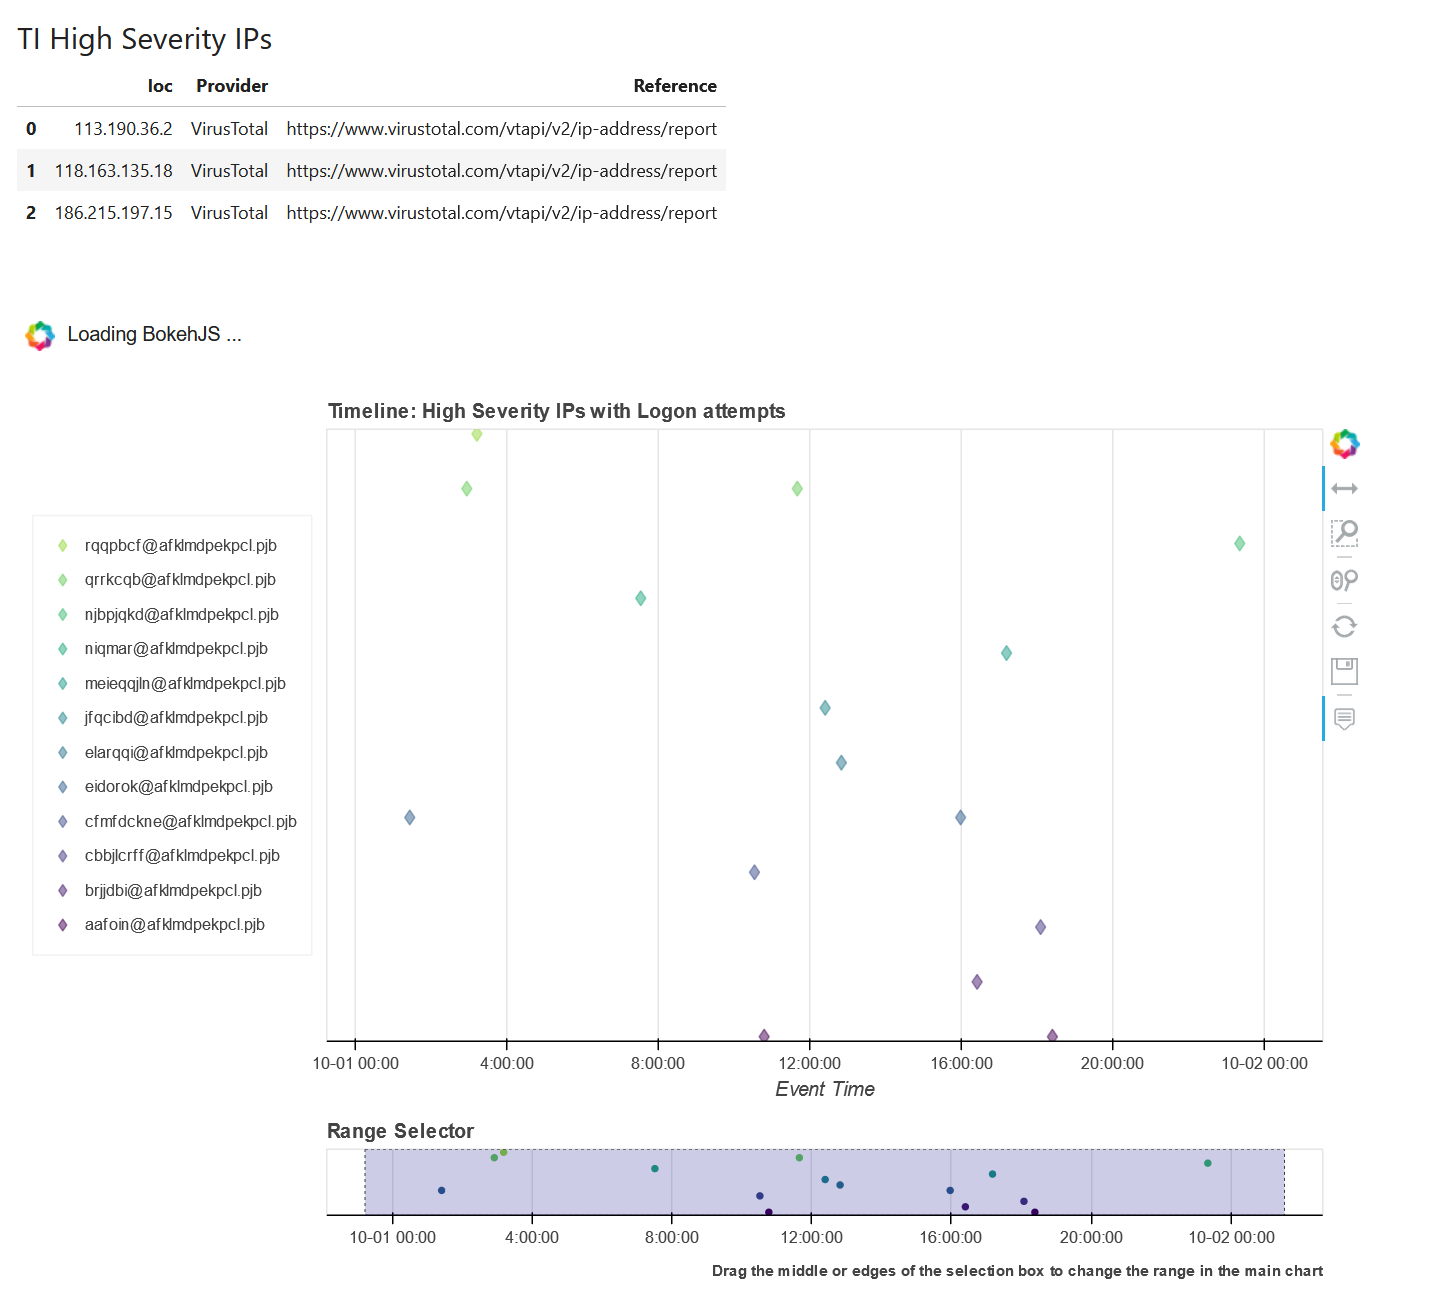

In [105]:
from IPython.display import Image
Image("data/pivot_pipeline.png", width=1000)